In [13]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import datetime
import warnings

#Sci-kit learn packages
from sklearn.linear_model import LinearRegression

In [14]:
# Get data
contacts_df = pd.read_csv('data/contacts.tsv', sep = '\t')
searches_df = pd.read_csv('data/searches.tsv', sep = '\t')

In [15]:
# Contacts info
contacts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7823 entries, 0 to 7822
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id_guest        7823 non-null   object
 1   id_host         7823 non-null   object
 2   id_listing      7823 non-null   object
 3   ts_contact_at   7823 non-null   object
 4   ts_reply_at     7219 non-null   object
 5   ts_accepted_at  3627 non-null   object
 6   ts_booking_at   2174 non-null   object
 7   ds_checkin      7823 non-null   object
 8   ds_checkout     7823 non-null   object
 9   n_guests        7823 non-null   int64 
 10  n_messages      7823 non-null   int64 
dtypes: int64(2), object(9)
memory usage: 672.4+ KB


In [16]:
# Searches info
searches_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35737 entries, 0 to 35736
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ds                    35737 non-null  object 
 1   id_user               35737 non-null  object 
 2   ds_checkin            23888 non-null  object 
 3   ds_checkout           23888 non-null  object 
 4   n_searches            35737 non-null  int64  
 5   n_nights              23888 non-null  float64
 6   n_guests_min          35737 non-null  int64  
 7   n_guests_max          35737 non-null  int64  
 8   origin_country        35737 non-null  object 
 9   filter_price_min      13322 non-null  float64
 10  filter_price_max      13322 non-null  float64
 11  filter_room_types     16191 non-null  object 
 12  filter_neighborhoods  1346 non-null   object 
dtypes: float64(3), int64(3), object(7)
memory usage: 3.5+ MB


/Users/yumengliu/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/yumengliu/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 1.0, 'Inquiry times')

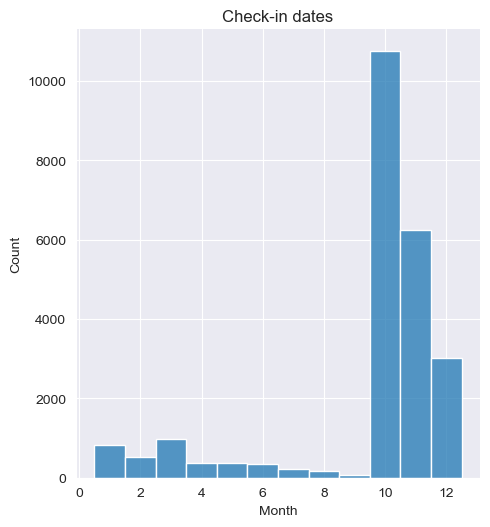

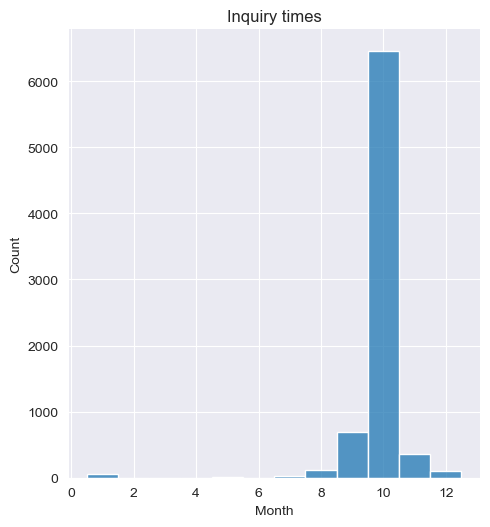

In [17]:
def get_month(date_time):
    if type(date_time) == str:
        return int(date_time[5:7])
    else:
        return date_time
    
month_check_in = pd.Series(map(get_month, searches_df['ds_checkin']))
sn.displot(data=month_check_in, discrete=True)
plt.xlabel("Month")
plt.title("Check-in dates")

    
month_check_in = pd.Series(map(get_month, contacts_df['ts_contact_at']))
sn.displot(data=month_check_in, discrete=True)

plt.xlabel("Month")
plt.title("Inquiry times")

/Users/yumengliu/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


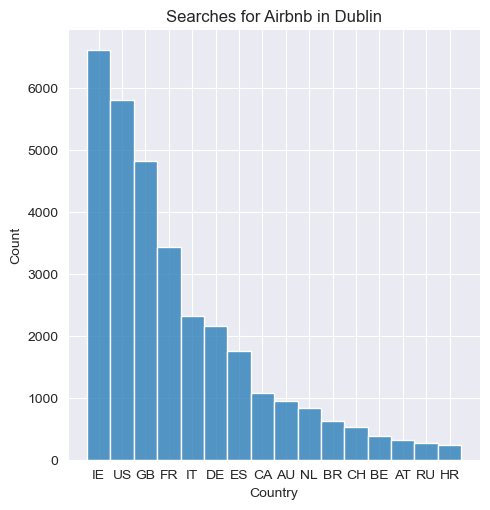

In [18]:
def show_search_countries(min_count: int=800):
    # Show the most frequent origin search countries 
    
    # Origin country
    origin_country = searches_df['origin_country']
    og_country_counts = origin_country.value_counts()
    og_country_counts = pd.DataFrame({'Country': og_country_counts.index, 'Count': og_country_counts.values})
    
    # Filter for countries with more than [filter] searches
    og_country_counts = og_country_counts.loc[og_country_counts['Count'] > min_count]
    sn.displot(data=og_country_counts, x='Country', weights='Count')

    plt.title('Searches for Airbnb in Dublin')


show_search_countries(200)


In [19]:
# Merge the join the contact data frame with the search data frame based on the id_guest
merged = pd.concat([searches_df, contacts_df], axis=1, join='inner').reindex(contacts_df.index)
merged = merged.loc[:,~merged.columns.duplicated()]

# Add data field "price_range"
merged['filter_price_min'].fillna(0, inplace=True)
merged['filter_price_max'].fillna(1073741823, inplace=True)
merged['price_range'] = merged['filter_price_max'] - merged['filter_price_min']


# Add a 'booked' column to represent if the contact led to booked
merged['booked'] = pd.Series(map(lambda x: type(x) == str, merged['ts_booking_at']))

#Add a month column
merged['month_checkin'] = pd.Series(map(get_month, merged['ds_checkin']))

#Remove null values
merged['n_nights'].fillna(1, inplace = True)

merged.info()

# Data field used in the training
#   Column       Non-Null Count  Dtype  
#---  ------       --------------  -----  
# 0   n_searches   7823 non-null   int64  
# 1   n_nights     7823 non-null   float64
# 2   n_guests     7823 non-null   int64  
# 3   n_messages   7823 non-null   int64  
# 4   price_range  7823 non-null   float64
# 5   booked       7823 non-null   int64  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7823 entries, 0 to 7822
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ds                    7823 non-null   object 
 1   id_user               7823 non-null   object 
 2   ds_checkin            5279 non-null   object 
 3   ds_checkout           5279 non-null   object 
 4   n_searches            7823 non-null   int64  
 5   n_nights              7823 non-null   float64
 6   n_guests_min          7823 non-null   int64  
 7   n_guests_max          7823 non-null   int64  
 8   origin_country        7823 non-null   object 
 9   filter_price_min      7823 non-null   float64
 10  filter_price_max      7823 non-null   float64
 11  filter_room_types     3461 non-null   object 
 12  filter_neighborhoods  300 non-null    object 
 13  id_guest              7823 non-null   object 
 14  id_host               7823 non-null   object 
 15  id_listing           

In [20]:
ireland = merged[merged['origin_country'] == 'IE']
#print(len(merged))
#print(ireland['booked'].value_counts())
print(ireland['n_nights'].describe())


us = merged[merged['origin_country'] == 'US']
# print(us['booked'].value_counts())
print(us['n_nights'].describe())



britain = merged[merged['origin_country'] == 'GB']
# print(britain['booked'].value_counts())
print(britain['n_nights'].describe())


france = merged[merged['origin_country'] == 'FR']
# print(france['booked'].value_counts())
print(france['n_nights'].describe())


italy = merged[merged['origin_country'] == 'IT']
# print(italy['booked'].value_counts())
print(italy['n_nights'].describe())




count    1526.000000
mean        5.503277
std        23.060768
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max       392.000000
Name: n_nights, dtype: float64
count    1309.000000
mean        4.400306
std        14.834877
min         0.000000
25%         1.000000
50%         2.000000
75%         4.000000
max       366.000000
Name: n_nights, dtype: float64
count    1062.000000
mean        3.482109
std        12.632303
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max       357.000000
Name: n_nights, dtype: float64
count    722.000000
mean       5.196676
std       16.335087
min        1.000000
25%        1.000000
50%        3.000000
75%        4.000000
max      265.000000
Name: n_nights, dtype: float64
count    494.000000
mean       6.757085
std       15.512009
min        1.000000
25%        1.000000
50%        3.000000
75%        5.000000
max      223.000000
Name: n_nights, dtype: float64


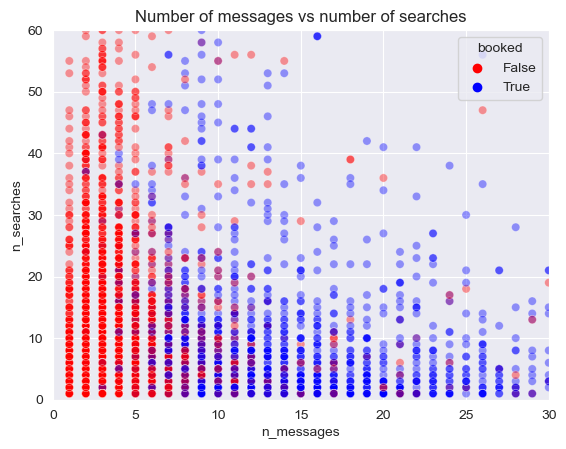

In [21]:
fig, ax = plt.subplots()
sn.scatterplot(data=merged, x='n_messages', y='n_searches', hue='booked', palette=['red', 'blue'], alpha=0.4, ax=ax)
ax.set_xlim(0, 30)
ax.set_ylim(0, 60)
plt.title('Number of messages vs number of searches')
plt.show(ax)


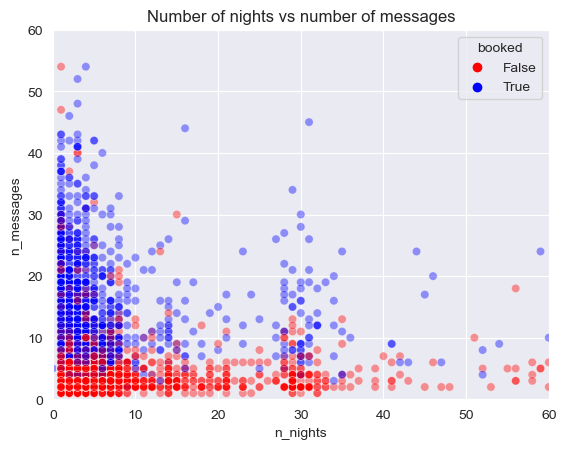

In [22]:
fig, ax = plt.subplots()
sn.scatterplot(data=merged, x='n_nights', y='n_messages', hue='booked', palette=['red', 'blue'], alpha=0.4, ax=ax)
ax.set_xlim(0, 60)
ax.set_ylim(0, 60)
plt.title('Number of nights vs number of messages')
plt.show(ax)


In [23]:
# Look at filter room types

merged['filter_room_types'].value_counts()

def cleanup_filter_room_types():
    merged['filter_room_types'] = merged['filter_room_types'].replace({',Entire home/apt': 'Entire home/apt', 
    ',Private room': 'Private room', ',Entire home/apt,Entire home/apt,Private room':'Entire home/apt,Private room',
    ',Entire home/apt,Private room': 'Entire home/apt,Private room', ',Entire home/apt,Entire home/apt,Private room,Private room':
    'Entire home/apt,Private room', ',Entire home/apt,Private room,Private room':'Entire home/apt,Private room', 
    ',Private room,Entire home/apt':'Entire home/apt,Private room', ',Shared room':'Shared room'})

cleanup_filter_room_types()

In [24]:
merged['filter_room_types'].value_counts()

filter_room_types
Entire home/apt                                                                                                                                                         2111
Private room                                                                                                                                                             628
Entire home/apt,Private room                                                                                                                                             408
Shared room                                                                                                                                                               39
Private room,Entire home/apt                                                                                                                                              29
                                                                                                                     

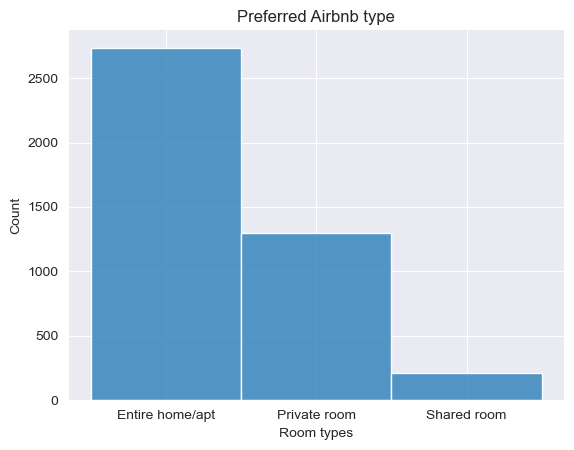

In [25]:
def count_filter_room_type():
    filter_room_types = pd.DataFrame({'Room types': []})
    for index, row in merged.iterrows():
        if type(row['filter_room_types']) is str:
            elements = np.unique(row['filter_room_types'].split(','))
            for i in elements:
                if i:
                    filter_room_types.loc[len(filter_room_types['Room types'])] = i
        
    counts = filter_room_types['Room types'].value_counts()
    counts = pd.DataFrame({'Room types': counts.index, 'Count': counts.values})
    sn.histplot(data=counts, x='Room types', weights='Count')
    sn.despine()
    plt.title('Preferred Airbnb type')

count_filter_room_type()


# Exploratory Data Analysis Findings

- Peak check-in time is October (most customers want to visit Dublin at this time)

- The most frequently-searched room type is entire home/apt

- At the peak-time, the number of messages for inquiries increases, and the chance a customer books an Airbnb decreases

In [26]:
!pip install kneed==0.8.5

In [27]:


from sklearn.cluster import OPTICS
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
from sklearn.cluster import OPTICS, KMeans
from sklearn.preprocessing import normalize, StandardScaler


# Turn 'booked' into int
merged['booked'] = merged['booked'].astype(int)

def is_num(x):
    return x.dtype == int or x.dtype == float

features = [i for i in merged.columns if is_num(merged[i])]
features.remove('filter_price_min')
features.remove('filter_price_max')
features.remove('n_guests_min')
features.remove('n_guests_max')
features.remove('month_checkin')

merged[features].info()


scaler = StandardScaler()
X_val_scaled = scaler.fit_transform(merged[features]) # Scale to standardized score
X_val_normalized = normalize(X_val_scaled) # Get values to Normal distribution



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7823 entries, 0 to 7822
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   n_searches   7823 non-null   int64  
 1   n_nights     7823 non-null   float64
 2   n_guests     7823 non-null   int64  
 3   n_messages   7823 non-null   int64  
 4   price_range  7823 non-null   float64
 5   booked       7823 non-null   int64  
dtypes: float64(2), int64(4)
memory usage: 366.8 KB


In [28]:
# Building the Kmeans Clustering model

def train_k_means(data: pd.DataFrame):
    #Find optimal n_clusters
    elbow_data_pts = []
    for num in range(1, 20):
        k_means = KMeans(init = "k-means++", n_clusters = num, n_init = 20)
        k_means.fit(data)
        elbow_data_pts.append(k_means.inertia_) #Error

    from kneed import KneeLocator
    kneedle = KneeLocator(x = range(1, 20), y = elbow_data_pts, curve = "convex", direction = "decreasing")
    elbow_pt = kneedle.elbow

    #Do K-Means Cluster w/ optimal n_clusters
    true_k_means = KMeans(init = "k-means++", n_clusters = elbow_pt, n_init = 20)
    true_k_means.fit(data)

    return true_k_means

k_means = train_k_means(X_val_normalized)

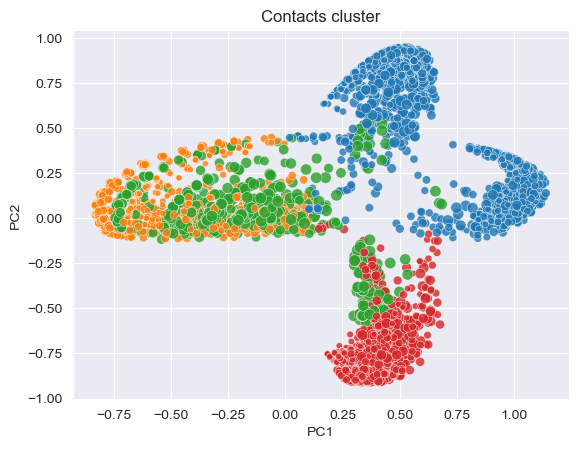

In [29]:
# Plotting the OPTICS Clustering
from sklearn.decomposition import PCA

pca = PCA(3) 
pca_data = pd.DataFrame(pca.fit_transform(X_val_normalized),columns=['PC1','PC2', 'PC3'])
pca_data['cluster'] = pd.Categorical(k_means.labels_)

ax = plt.subplots()[1]
sn.scatterplot(x="PC1",y="PC2",hue="cluster",data=pca_data, size='PC3', alpha=0.8, ax=ax,
legend = False)
ax.set_title('Contacts cluster')
plt.show(ax)


# Findings for customers

In [30]:
normalized_data_dict = {key: X_val_normalized[:, merged[features].columns.get_loc(key)] for key in merged[features].columns}
normalized_data_dict['labels'] = k_means.labels_.astype(float)
normalized_data_dict = pd.DataFrame(normalized_data_dict)


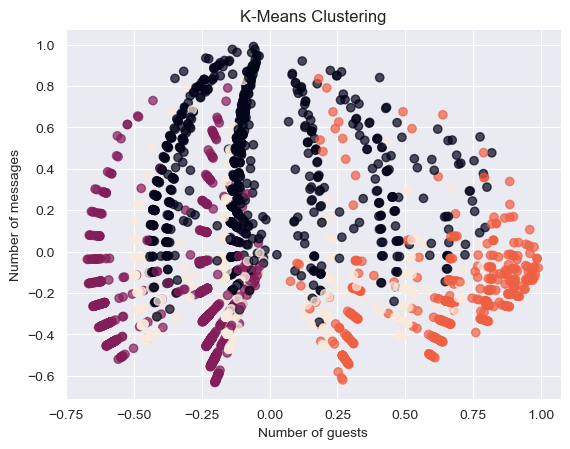

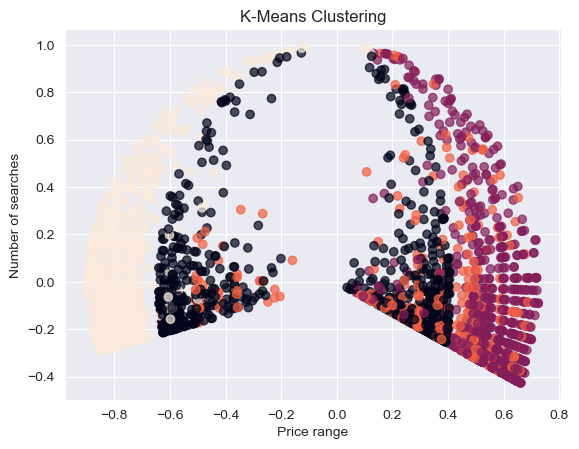

In [31]:
random_samples = normalized_data_dict.sample(3000)
labels = random_samples['labels']

plt.scatter(random_samples['n_guests'], random_samples['n_messages'], c=labels.astype(float), alpha=0.7)
plt.xlabel('Number of guests')
plt.ylabel('Number of messages')
plt.title("K-Means Clustering")
sn.despine(right=True) #Remove line on the right
plt.show()
plt.close()


plt.scatter(random_samples['price_range'], random_samples['n_searches'], c=labels.astype(float), alpha=0.7)
plt.xlabel('Price range')
plt.ylabel('Number of searches')
plt.title("K-Means Clustering")
sn.despine(right=True) #Remove line on the right
plt.show()
plt.close()


In [32]:
merged['cluster'] = k_means.labels_
def look_at_cluster_characteristics(c):
    for i in range(4):
        cluster_i = merged[merged['cluster'] == i]
        print(f'Cluster {i}:')
        print(cluster_i[c].describe())

In [33]:
for i in features:
    look_at_cluster_characteristics(i)

Cluster 0:
count    2202.000000
mean        9.939600
std        20.277056
min         1.000000
25%         2.000000
50%         4.000000
75%        10.000000
max       344.000000
Name: n_searches, dtype: float64
Cluster 1:
count    2571.000000
mean        6.989887
std        11.439364
min         1.000000
25%         1.000000
50%         3.000000
75%         8.000000
max       108.000000
Name: n_searches, dtype: float64
Cluster 2:
count    1215.000000
mean        7.074897
std        12.719771
min         1.000000
25%         1.000000
50%         3.000000
75%         8.000000
max       182.000000
Name: n_searches, dtype: float64
Cluster 3:
count    1835.000000
mean       14.870300
std        25.056872
min         1.000000
25%         3.000000
50%         8.000000
75%        16.000000
max       400.000000
Name: n_searches, dtype: float64
Cluster 0:
count    2202.000000
mean        7.550409
std        30.362589
min         0.000000
25%         1.000000
50%         2.000000
75%         4.0

In [34]:
for i in range(4):
        cluster_i = merged[merged['cluster'] == i]
        print(f'Cluster {i}:')
        print(len(cluster_i))
        print(cluster_i['origin_country'].value_counts())

Cluster 0:
2202
origin_country
IE    441
US    358
GB    297
FR    191
IT    155
     ... 
BG      1
MK      1
GE      1
CO      1
NG      1
Name: count, Length: 68, dtype: int64
Cluster 1:
2571
origin_country
IE    566
US    418
GB    372
FR    218
IT    144
     ... 
PH      1
BM      1
IS      1
DO      1
NI      1
Name: count, Length: 77, dtype: int64
Cluster 2:
1215
origin_country
IE    262
US    217
GB    169
FR     97
IT     75
     ... 
HU      1
SI      1
LV      1
PR      1
PH      1
Name: count, Length: 61, dtype: int64
Cluster 3:
1835
origin_country
US    316
IE    257
GB    224
FR    216
DE    123
     ... 
MA      1
MK      1
PA      1
DO      1
IN      1
Name: count, Length: 68, dtype: int64


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=69f32c3a-1666-4be0-997d-586065ca44e9' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>